In [49]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


def show_rgb_image(image, title=None, conversion=cv2.COLOR_BGR2RGB):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    image = cv2.cvtColor(image, conversion)

    # Show the image
    #make the image larger
    plt.figure(figsize=(15, 10))
    plt.imshow(image)

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()


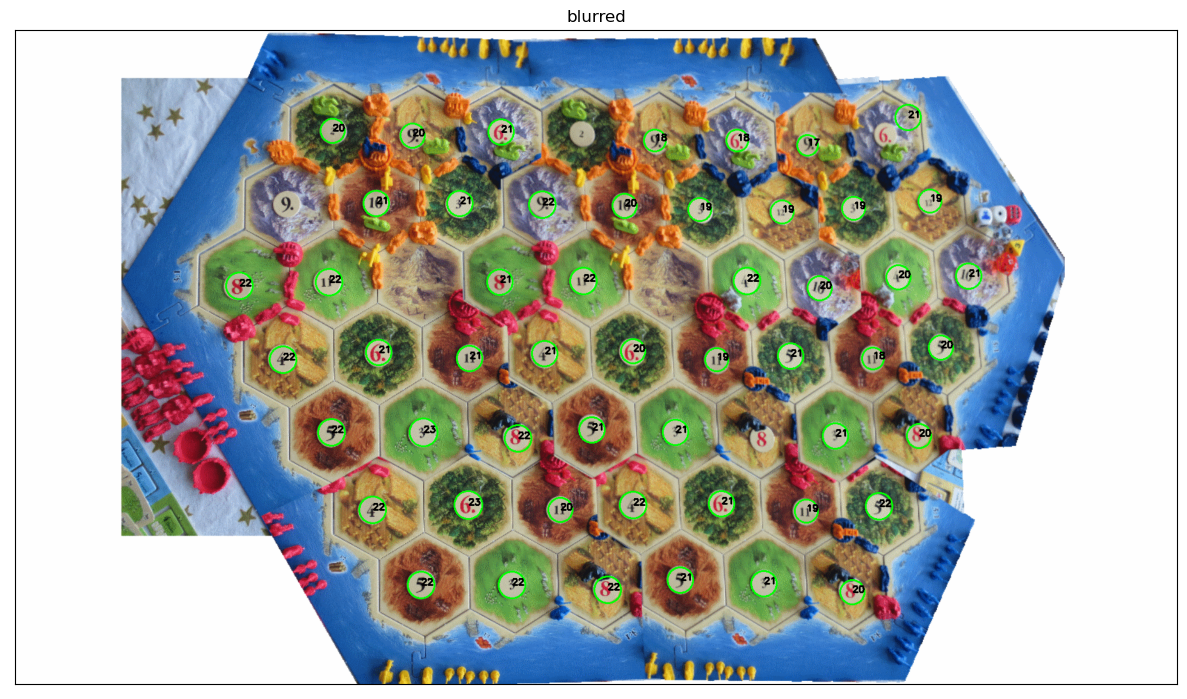

In [48]:
img = cv2.imread('big field.png')

processed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#show_rgb_image(processed, 'grey')
#make evrything above 160 white aberythign below black
processed = cv2.GaussianBlur(processed, (5, 5), 0)
processed = cv2.threshold(processed, 170, 255, cv2.THRESH_BINARY)[1]
#run edge detect on image
processed = cv2.Canny(processed, 200, 200)


In [ ]:
minDist = 100
param1 = 30  # 500
param2 = 18  # 200 #smaller value-> more false circles
minRadius = 15
maxRadius = 25  # 10

# docstring of HoughCircles: HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) -> circles
circles = cv2.HoughCircles(processed, cv2.HOUGH_GRADIENT, 1, minDist,
                           param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)
        #print the size next to it
        cv2.putText(img, str(i[2]), (i[0], i[1]),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

show_rgb_image(img, 'blurred')
